<a href="https://colab.research.google.com/github/hasune613/hello-world/blob/main/George_bert_inner_workings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 11.5 MB/s 
     |████████████████████████████████| 6.5 MB 43.1 MB/s 
     |████████████████████████████████| 895 kB 50.7 MB/s 


In [2]:
import math
import torch
from transformers.activations import gelu
from transformers import (
    BertTokenizer, BertConfig,BertForSequenceClassification, BertPreTrainedModel,
    apply_chunking_to_forward, set_seed
)
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    SequenceClassifierOutput
)

set_seed(123)
n_labels = 2
ACT2FN = {'gelu' : gelu}
BertLayerNorm = torch.nn.LayerNorm

In [3]:
input_texts = ['I love cats!',
               'He hates pinapple pizza.']
labels = [1,0]

In [4]:
# Create BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

input_sequences = tokenizer(input_texts, add_special_tokens=True, padding=True, truncation=True, return_tensors='pt')
# input_sequences 
input_sequences.update({'labels':torch.tensor(labels)})
print('PRETTY PRINT OF `input_sequences `UPDATED WITH `labels`:')
[print('%s : %s\n' %(k,v)) for k, v in input_sequences.items()]
print('ORIGINAL TEXT')
[print(example) for example in input_texts];
[print(example) for example in input_sequences['input_ids']];
print('\nTEXT AFTER USING `BertTokenizer`:')
[print(tokenizer.decode(example)) for example in input_sequences['input_ids'].numpy()];




Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

PRETTY PRINT OF `input_sequences `UPDATED WITH `labels`:
input_ids : tensor([[  101,   146,  1567, 11771,   106,   102,     0,     0,     0],
        [  101,  1124, 18457, 10473, 11478,  7136, 13473,   119,   102]])

token_type_ids : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])

attention_mask : tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])

labels : tensor([1, 0])

ORIGINAL TEXT
I love cats!
He hates pinapple pizza.
tensor([  101,   146,  1567, 11771,   106,   102,     0,     0,     0])
tensor([  101,  1124, 18457, 10473, 11478,  7136, 13473,   119,   102])

TEXT AFTER USING `BertTokenizer`:
[CLS] I love cats! [SEP] [PAD] [PAD] [PAD]
[CLS] He hates pinapple pizza. [SEP]


In [5]:
# config
bert_config = BertConfig.from_pretrained('bert-base-cased')
bert_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [6]:
# レイヤー数
print('NUMBER OF LAYERS:', bert_config.num_hidden_layers)

NUMBER OF LAYERS: 12


In [7]:
# BertのEmbeddingサイズ
print('EMBEDDING SIZE:',bert_config.hidden_size)

EMBEDDING SIZE: 768


In [8]:
# 活性化関数の確認
print('ACTIVATIONS :',bert_config.hidden_act)

ACTIVATIONS : gelu


In [9]:
model = BertForSequenceClassification.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [10]:
# model

In [11]:
with torch.no_grad():
    output = model.forward(**input_sequences)
# print()

print('FORWARD PASS OUTPUT:', output)

FORWARD PASS OUTPUT: SequenceClassifierOutput(loss=tensor(0.6980), logits=tensor([[0.1236, 0.6943],
        [0.1855, 0.6432]]), hidden_states=None, attentions=None)


In [12]:
import torch.nn as nn

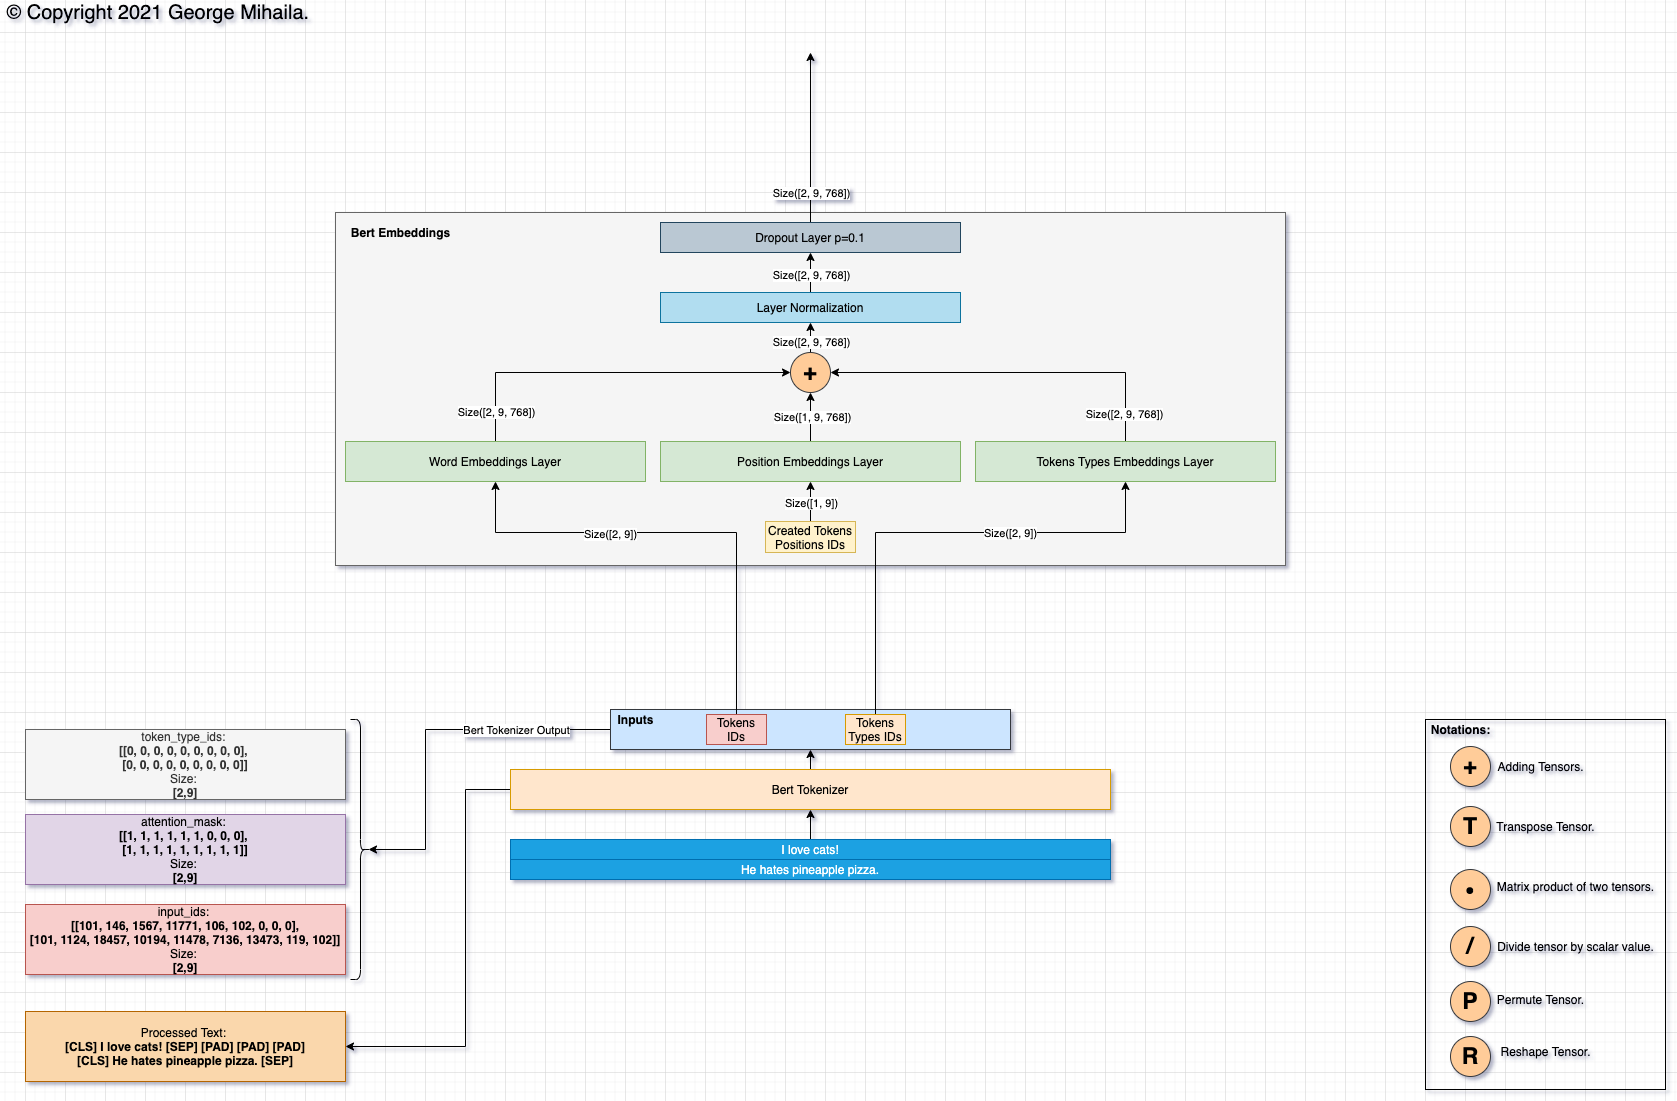

In [13]:
class BertEmbeddings(torch.nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = torch.nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = torch.nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = torch.nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = torch.nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

        # ADDED
        print('Created Tokens Positions IDs:\n', position_ids)
        

        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # ADDED
        print('\nTokens IDs:\n', input_ids.shape)
        print('\nTokens Type IDs:\n', token_type_ids.shape)
        print('\nWord Embeddings:\n', inputs_embeds.shape)

        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)

            # ADDED
            print('\nPosition Embeddings:\n', position_embeddings.shape)

            embeddings += position_embeddings

        # ADDED
        print('\nToken Types Embeddings:\n', token_type_embeddings.shape)
        print('\nSum Up All Embeddings:\n', embeddings.shape)

        embeddings = self.LayerNorm(embeddings)

        # ADDED
        print('\nEmbeddings Layer Nromalization:\n', embeddings.shape)

        embeddings = self.dropout(embeddings)

        # ADDED
        print('\nEmbeddings Dropout Layer:\n', embeddings.shape)
        
        return embeddings


# Create Bert embedding layer.
bert_embeddings_block = BertEmbeddings(bert_config)

# Perform a forward pass.
embedding_output = bert_embeddings_block.forward(input_ids=input_sequences['input_ids'], token_type_ids=input_sequences['token_type_ids'])

Created Tokens Positions IDs:
 tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8]])

Tokens IDs:
 torch.Size([2, 9])

Tokens Type IDs:
 torch.Size([2, 9])

Word Embeddings:
 torch.Size([2, 9, 768])

Position Embeddings:
 torch.Size([1, 9, 768])

Token Types Embeddings:
 torch.Size([2, 9, 768])

Sum Up All Embeddings:
 torch.Size([2, 9, 768])

Embeddings Layer Nromalization:
 torch.Size([2, 9, 768])

Embeddings Dropout Layer:
 torch.Size([2, 9, 768])


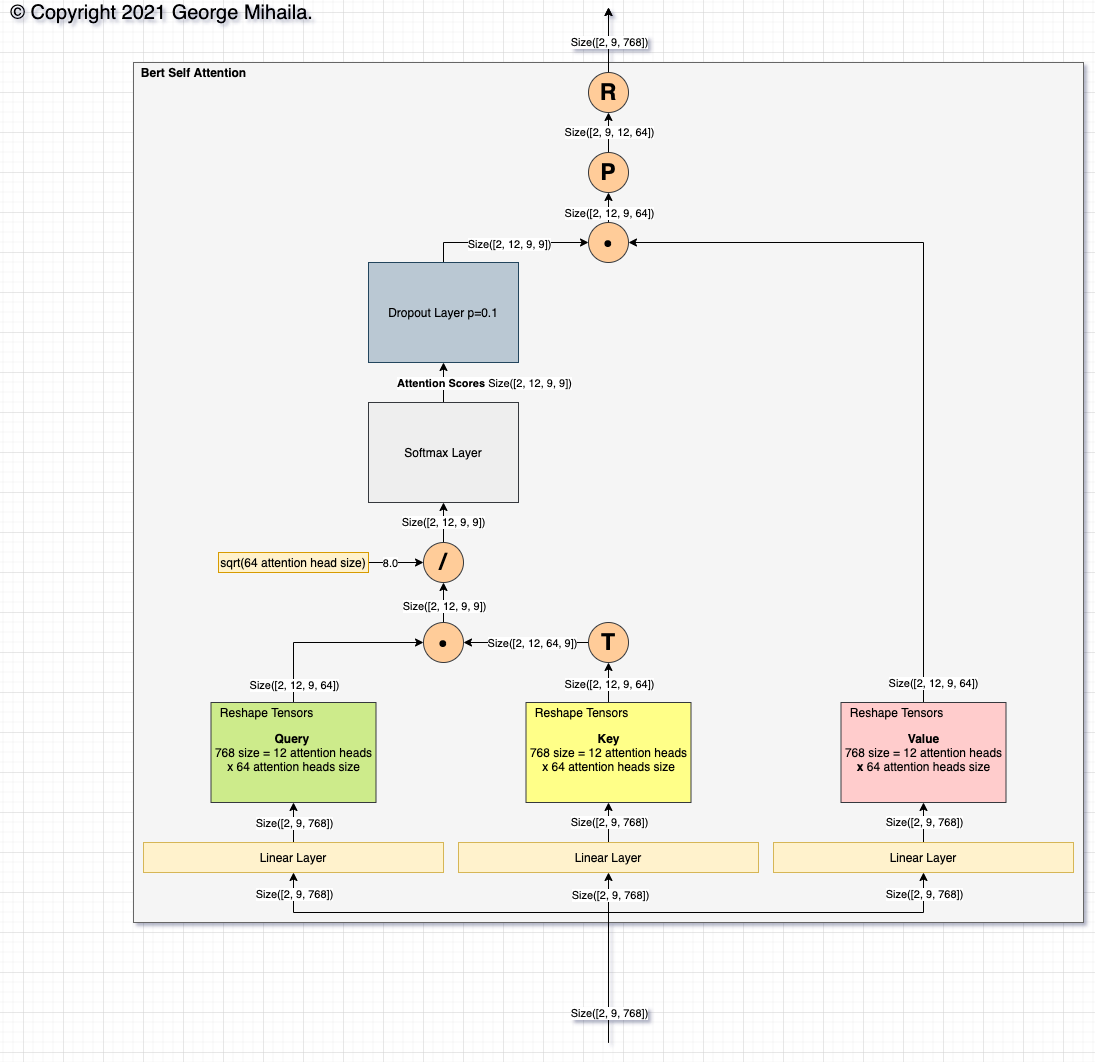

In [14]:
class BertSelfAttention(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # ADDED
        print('Attention Head Size:\n', self.attention_head_size)
        print('\nCombined Attentions Head Size:\n', self.all_head_size)

        self.query = torch.nn.Linear(config.hidden_size, self.all_head_size)
        self.key = torch.nn.Linear(config.hidden_size, self.all_head_size)
        self.value = torch.nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = torch.nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        # ADDED
        print('\nHidden States:\n', hidden_states.shape)

        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:

            # ADDED
            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', past_key_value[0].shape)
            print('\nValue Linear Layer:\n', past_key_value[1].shape)

            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:

            # ADDED
            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', self.key(encoder_hidden_states).shape)
            print('\nValue Linear Layer:\n', self.value(encoder_hidden_states).shape)

            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:

            # ADDED
            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', self.key(hidden_states).shape)
            print('\nValue Linear Layer:\n', self.value(hidden_states).shape)

            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:

            # ADDED
            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', self.key(hidden_states).shape)
            print('\nValue Linear Layer:\n', self.value(hidden_states).shape)

            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        
        

        query_layer = self.transpose_for_scores(mixed_query_layer)

        # ADDED
        print('\nQuery:\n', query_layer.shape)
        print('\nKey:\n', key_layer.shape)
        print('\nValue:\n', value_layer.shape)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # ADDED
        print('\nKey Transposed:\n', key_layer.transpose(-1, -2).shape)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        # ADDED
        print('\nAttention Scores:\n', attention_scores.shape)

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # ADDED
        print('\nAttention Scores Divided by Scalar:\n', attention_scores.shape)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)

        # ADDED
        print('\nAttention Probabilities Softmax Layer:\n', attention_probs.shape)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # ADDED
        print('\nAttention Probabilities Dropout Layer:\n', attention_probs.shape)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        # ADDED
        print('\nContext:\n', context_layer.shape)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()

        # ADDED
        print('\nContext Permute:\n', context_layer.shape)

        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        # ADDED
        print('\nContext Reshaped:\n', context_layer.shape)
        
        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

# Create bert self attention layer.
bert_selfattention_block = BertSelfAttention(bert_config)

# Perform a forward pass.
context_embedding = bert_selfattention_block.forward(hidden_states=embedding_output)

Attention Head Size:
 64

Combined Attentions Head Size:
 768

Hidden States:
 torch.Size([2, 9, 768])

Query Linear Layer:
 torch.Size([2, 9, 768])

Key Linear Layer:
 torch.Size([2, 9, 768])

Value Linear Layer:
 torch.Size([2, 9, 768])

Query:
 torch.Size([2, 12, 9, 64])

Key:
 torch.Size([2, 12, 9, 64])

Value:
 torch.Size([2, 12, 9, 64])

Key Transposed:
 torch.Size([2, 12, 64, 9])

Attention Scores:
 torch.Size([2, 12, 9, 9])

Attention Scores Divided by Scalar:
 torch.Size([2, 12, 9, 9])

Attention Probabilities Softmax Layer:
 torch.Size([2, 12, 9, 9])

Attention Probabilities Dropout Layer:
 torch.Size([2, 12, 9, 9])

Context:
 torch.Size([2, 12, 9, 64])

Context Permute:
 torch.Size([2, 9, 12, 64])

Context Reshaped:
 torch.Size([2, 9, 768])


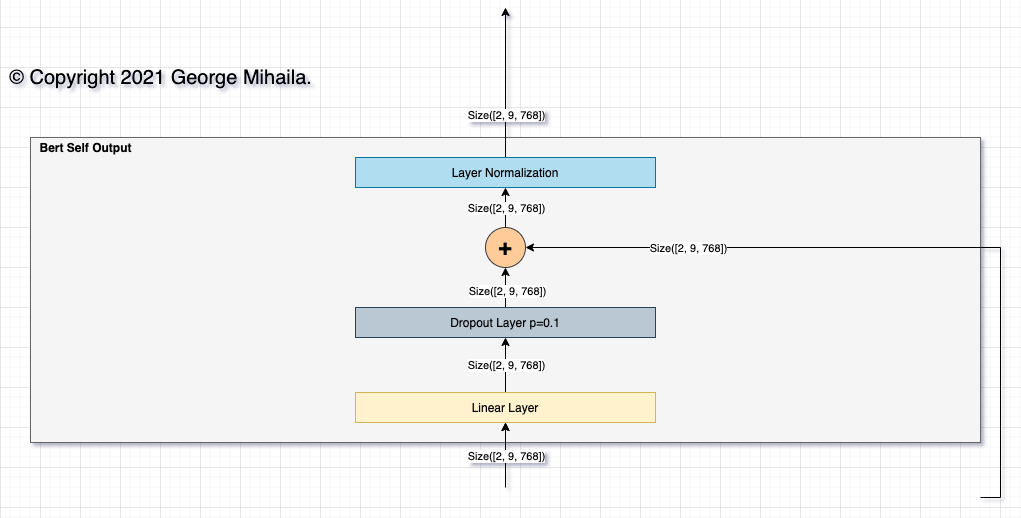

In [15]:
class BertSelfOutput(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        print('Hidden States:\n', hidden_states.shape)

        hidden_states = self.dense(hidden_states)
        print('\nHidden States Linear Layer:\n', hidden_states.shape)

        hidden_states = self.dropout(hidden_states)
        print('\nHidden States Dropout Layer:\n', hidden_states.shape)

        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        print('\nHidden States Normalization Layer:\n', hidden_states.shape)

        return hidden_states


# Create Bert self output layer.
bert_selfoutput_block = BertSelfOutput(bert_config)

# Perform a forward pass - context_embedding[0] because we have tuple.
attention_output = bert_selfoutput_block.forward(hidden_states=context_embedding[0], input_tensor=embedding_output)

Hidden States:
 torch.Size([2, 9, 768])

Hidden States Linear Layer:
 torch.Size([2, 9, 768])

Hidden States Dropout Layer:
 torch.Size([2, 9, 768])

Hidden States Normalization Layer:
 torch.Size([2, 9, 768])


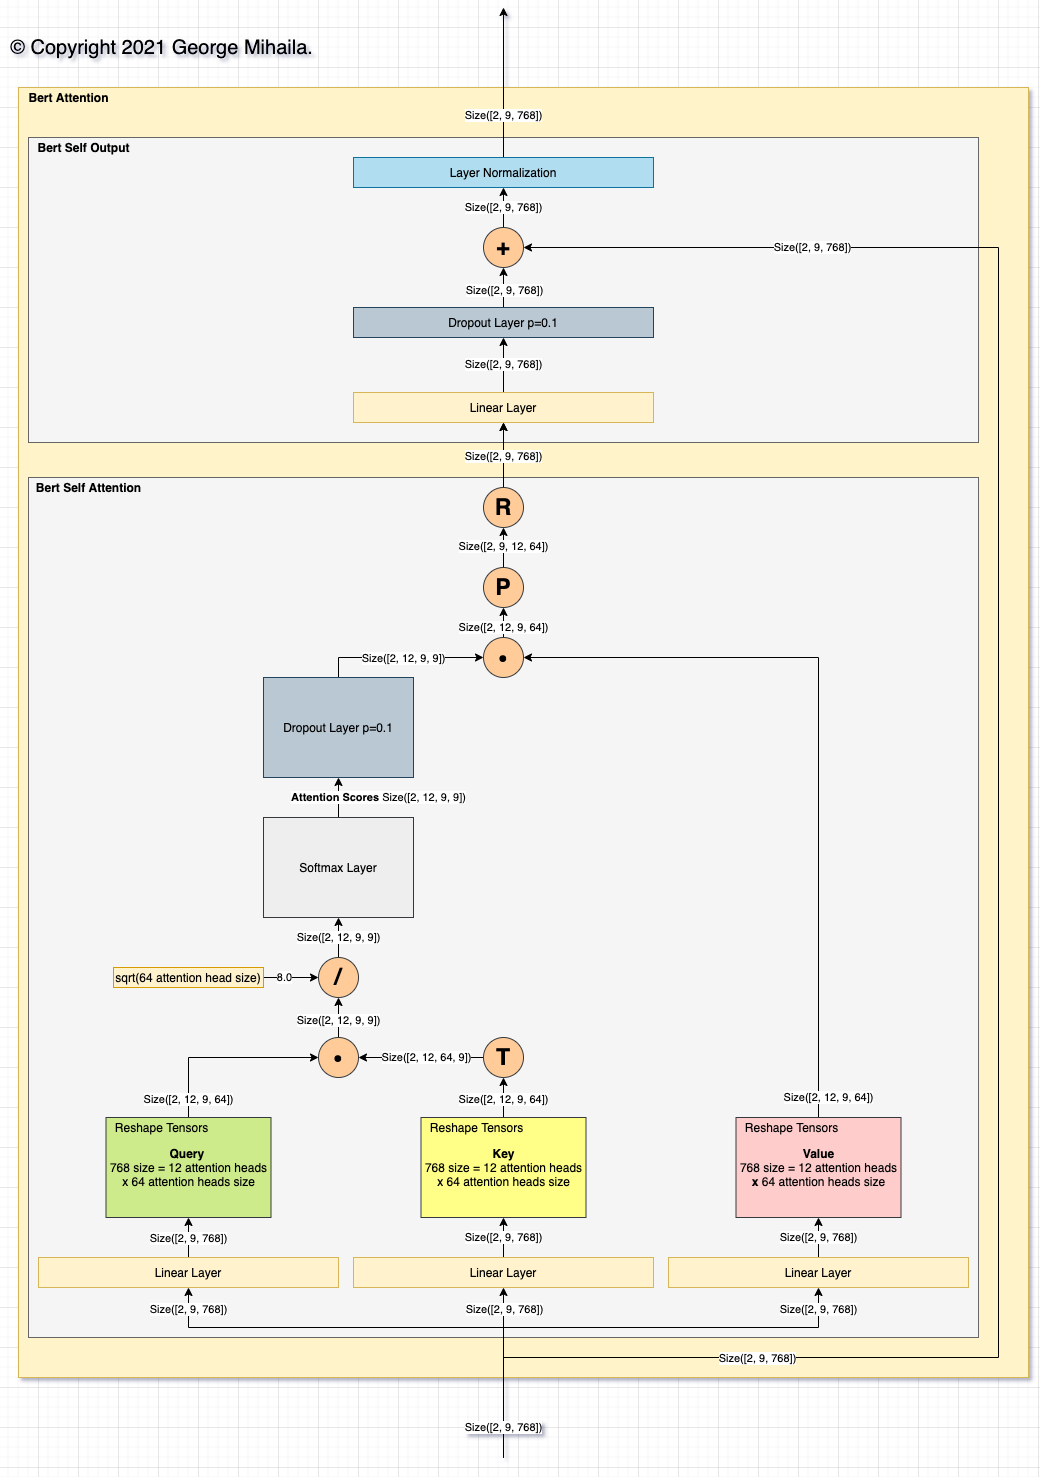

In [16]:
class BertAttention(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

# Create attention assembled layer.
bert_attention_block = BertAttention(bert_config)

# Perform a forward pass to wholte Bert Attention layer.
attention_output = bert_attention_block(hidden_states=embedding_output)

Attention Head Size:
 64

Combined Attentions Head Size:
 768

Hidden States:
 torch.Size([2, 9, 768])

Query Linear Layer:
 torch.Size([2, 9, 768])

Key Linear Layer:
 torch.Size([2, 9, 768])

Value Linear Layer:
 torch.Size([2, 9, 768])

Query:
 torch.Size([2, 12, 9, 64])

Key:
 torch.Size([2, 12, 9, 64])

Value:
 torch.Size([2, 12, 9, 64])

Key Transposed:
 torch.Size([2, 12, 64, 9])

Attention Scores:
 torch.Size([2, 12, 9, 9])

Attention Scores Divided by Scalar:
 torch.Size([2, 12, 9, 9])

Attention Probabilities Softmax Layer:
 torch.Size([2, 12, 9, 9])

Attention Probabilities Dropout Layer:
 torch.Size([2, 12, 9, 9])

Context:
 torch.Size([2, 12, 9, 64])

Context Permute:
 torch.Size([2, 9, 12, 64])

Context Reshaped:
 torch.Size([2, 9, 768])
Hidden States:
 torch.Size([2, 9, 768])

Hidden States Linear Layer:
 torch.Size([2, 9, 768])

Hidden States Dropout Layer:
 torch.Size([2, 9, 768])

Hidden States Normalization Layer:
 torch.Size([2, 9, 768])


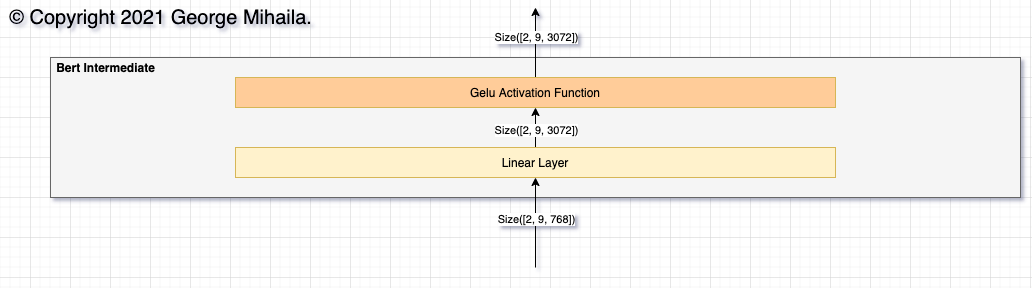

In [17]:
class BertIntermediate(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        print('\nHidden States:\n', hidden_states.shape)

        hidden_states = self.dense(hidden_states)
        print('\nHidden States Linear Layer:\n', hidden_states.shape)

        hidden_states = self.intermediate_act_fn(hidden_states)
        print('\nHidden States Gelu Activation Function:\n', hidden_states.shape)

        return hidden_states


# Create bert intermediate layer.
bert_intermediate_block = BertIntermediate(bert_config)

# Perform a forward pass - attention_output[0] because we have tuple.
intermediate_output = bert_intermediate_block.forward(hidden_states=attention_output[0])


Hidden States:
 torch.Size([2, 9, 768])

Hidden States Linear Layer:
 torch.Size([2, 9, 3072])

Hidden States Gelu Activation Function:
 torch.Size([2, 9, 3072])


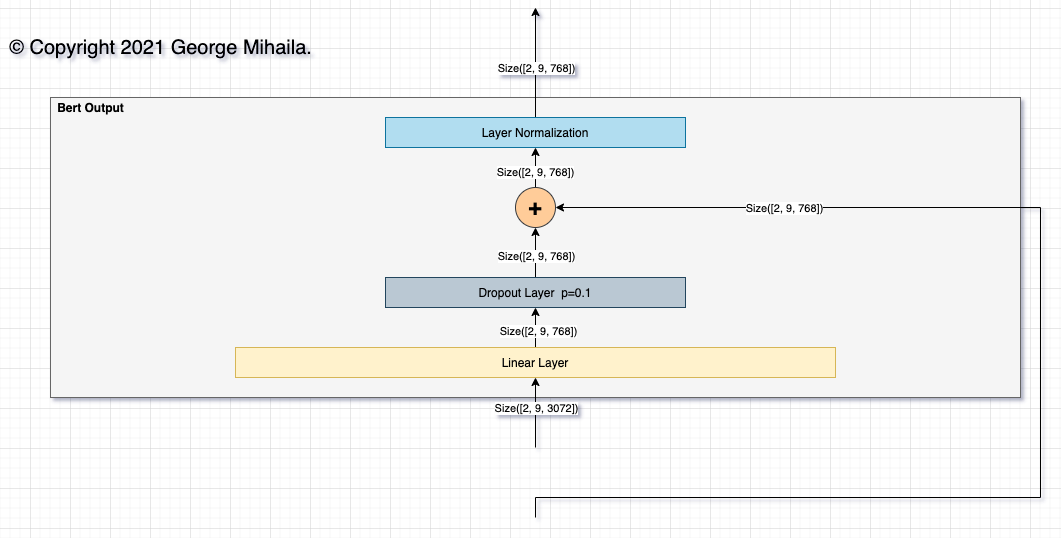

In [18]:
class BertOutput(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        print('\nHidden States:\n', hidden_states.shape)

        hidden_states = self.dense(hidden_states)
        print('\nHidden States Linear Layer:\n', hidden_states.shape)

        hidden_states = self.dropout(hidden_states)
        print('\nHidden States Dropout Layer:\n', hidden_states.shape)

        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        print('\nHidden States Layer Normalization:\n', hidden_states.shape)

        return hidden_states


# Create bert output layer.
bert_output_block = BertOutput(bert_config)

# Perform forward pass - attention_output[0] dealing with tuple.
layer_output = bert_output_block.forward(hidden_states=intermediate_output, input_tensor=attention_output[0])


Hidden States:
 torch.Size([2, 9, 3072])

Hidden States Linear Layer:
 torch.Size([2, 9, 768])

Hidden States Dropout Layer:
 torch.Size([2, 9, 768])

Hidden States Layer Normalization:
 torch.Size([2, 9, 768])


In [19]:
class BertLayer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(config)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            assert self.is_decoder, f"{self} should be used as a decoder model if cross attention is added"
            self.crossattention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            outputs = self_attention_outputs[1:-1]
            present_key_value = self_attention_outputs[-1]
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None:
            assert hasattr(
                self, "crossattention"
            ), f"If `encoder_hidden_states` are passed, {self} has to be instantiated with cross-attention layers by setting `config.add_cross_attention=True`"

            # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            cross_attention_outputs = self.crossattention(
                attention_output,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                cross_attn_past_key_value,
                output_attentions,
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

            # add cross-attn cache to positions 3,4 of present_key_value tuple
            cross_attn_present_key_value = cross_attention_outputs[-1]
            present_key_value = present_key_value + cross_attn_present_key_value

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder:
            outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output



# Assemble block to create Bert Layer.
bert_layer_block = BertLayer(bert_config)

# Perform feed forward on a whole Bert Layer.
layer_output = bert_layer_block.forward(hidden_states=embedding_output)

Attention Head Size:
 64

Combined Attentions Head Size:
 768

Hidden States:
 torch.Size([2, 9, 768])

Query Linear Layer:
 torch.Size([2, 9, 768])

Key Linear Layer:
 torch.Size([2, 9, 768])

Value Linear Layer:
 torch.Size([2, 9, 768])

Query:
 torch.Size([2, 12, 9, 64])

Key:
 torch.Size([2, 12, 9, 64])

Value:
 torch.Size([2, 12, 9, 64])

Key Transposed:
 torch.Size([2, 12, 64, 9])

Attention Scores:
 torch.Size([2, 12, 9, 9])

Attention Scores Divided by Scalar:
 torch.Size([2, 12, 9, 9])

Attention Probabilities Softmax Layer:
 torch.Size([2, 12, 9, 9])

Attention Probabilities Dropout Layer:
 torch.Size([2, 12, 9, 9])

Context:
 torch.Size([2, 12, 9, 64])

Context Permute:
 torch.Size([2, 9, 12, 64])

Context Reshaped:
 torch.Size([2, 9, 768])
Hidden States:
 torch.Size([2, 9, 768])

Hidden States Linear Layer:
 torch.Size([2, 9, 768])

Hidden States Dropout Layer:
 torch.Size([2, 9, 768])

Hidden States Normalization Layer:
 torch.Size([2, 9, 768])

Hidden States:
 torch.Size(

In [20]:
#BertLayerの12枚のレイヤーをまとめて、BertEncoderレイヤーを作る

class BertEncoder(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = torch.nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):

            # ADDED
            print('\n----------------- BERT LAYER %d -----------------'%(i+1))

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None
            if getattr(self.config, "gradient_checkpointing", False):

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

# create bert encoder block by stacking 12 layers
bert_encoder_block = BertEncoder(bert_config)

# perform forward pass on entire Bert Encoder
encoder_embedding = bert_encoder_block.forward(hidden_states=embedding_output)


Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768

----------------- BERT LAYER 1 -----------------

Hidden States:
 torch.Size([2, 9, 768])

Query Linear Layer:
 torch.Size([2, 9, 768])

Key Linear Layer:
 torch.Size([2, 9, 768])

Value Linear Layer:
 torch.Size([2, 9, 768])

Query:
 torch.Size([2, 12, 9

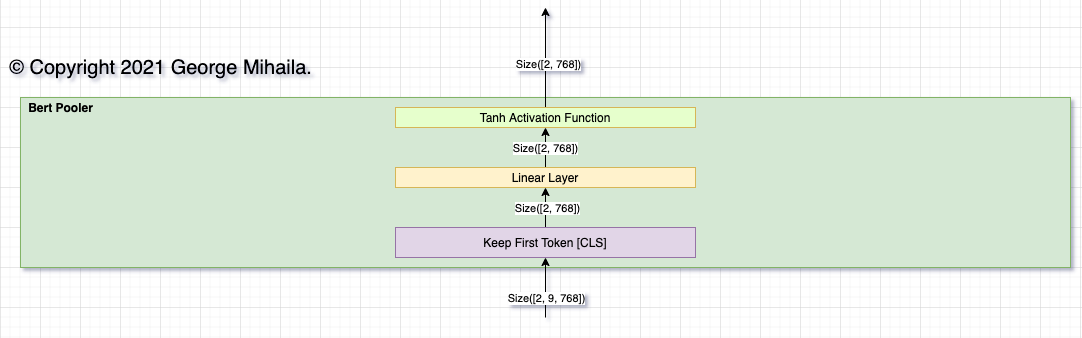

In [21]:
class BertPooler(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = torch.nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
       
        print('\nHidden States:\n', hidden_states.shape)

        first_token_tensor = hidden_states[:, 0]
        print('\nFirst Token [CLS]:\n', first_token_tensor.shape)

        pooled_output = self.dense(first_token_tensor)
        print('\nFirst Token [CLS] Linear Layer:\n', pooled_output.shape)

        pooled_output = self.activation(pooled_output)
        print('\nFirst Token [CLS] Tanh Activation Function:\n', pooled_output.shape)

        return pooled_output


# Create bert pooler block.
bert_pooler_block = BertPooler(bert_config)

# Perform forward pass - encoder_embedding[0] because it is a tuple.
pooled_output = bert_pooler_block(hidden_states=encoder_embedding[0])


Hidden States:
 torch.Size([2, 9, 768])

First Token [CLS]:
 torch.Size([2, 768])

First Token [CLS] Linear Layer:
 torch.Size([2, 768])

First Token [CLS] Tanh Activation Function:
 torch.Size([2, 768])


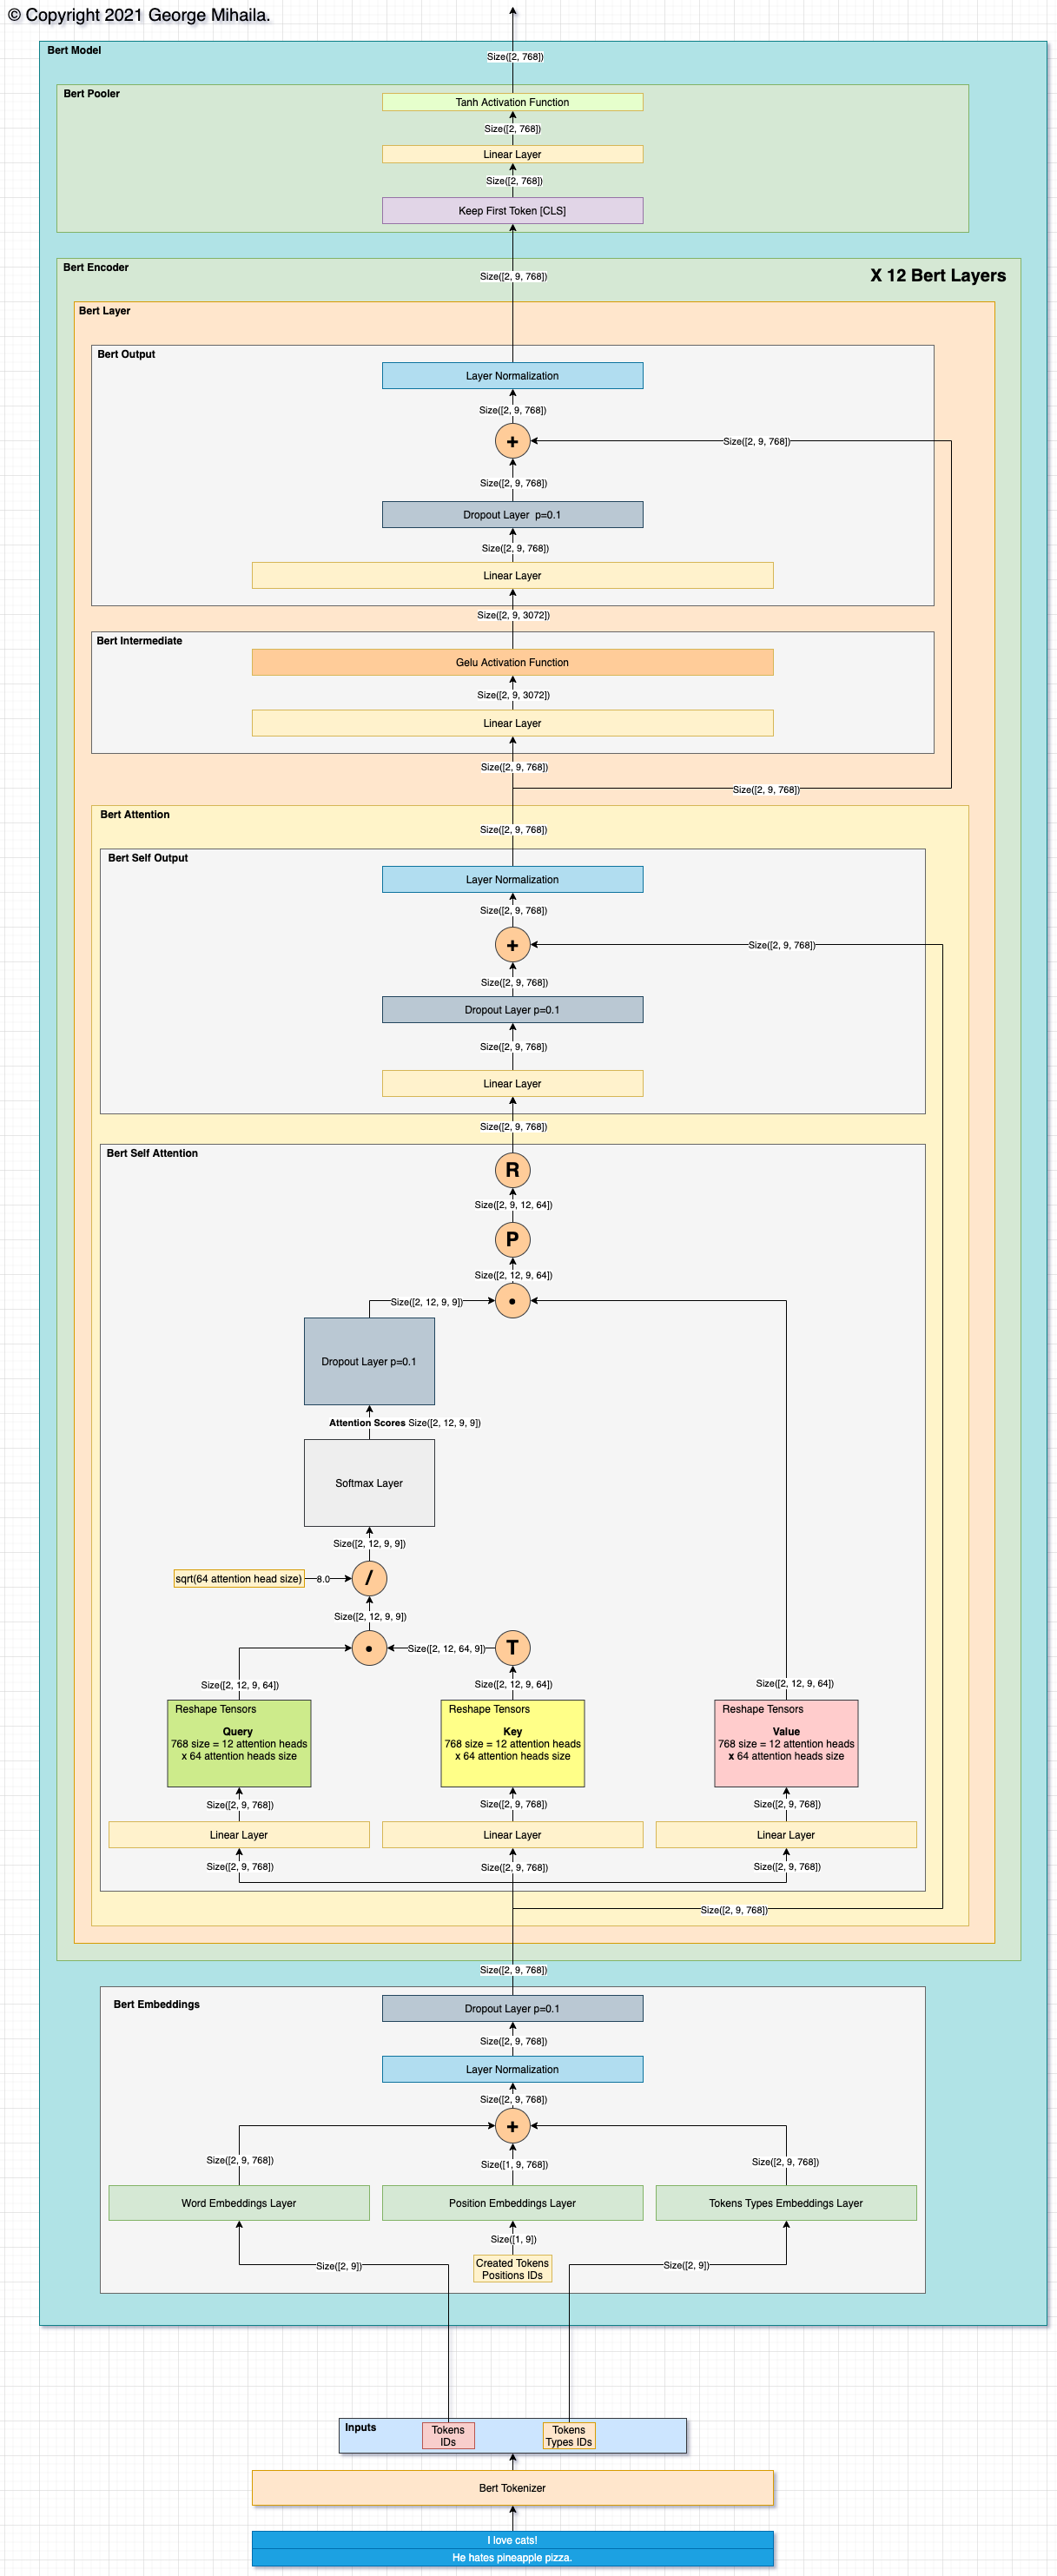

In [29]:
class BertModel(BertPreTrainedModel):
    """
    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in `Attention is
    all you need <https://arxiv.org/abs/1706.03762>`__ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.
    To behave as an decoder the model needs to be initialized with the :obj:`is_decoder` argument of the configuration
    set to :obj:`True`. To be used in a Seq2Seq model, the model needs to initialized with both :obj:`is_decoder`
    argument and :obj:`add_cross_attention` set to :obj:`True`; an :obj:`encoder_hidden_states` is then expected as an
    input to the forward pass.
    """

    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            batch_size, seq_length = input_shape
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size, seq_length = input_shape
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )


# Create bert model.
bert_model = BertModel(bert_config)

# Perform forward pass on entire model.
hidden_states = bert_model.forward(input_ids=input_sequences['input_ids'], attention_mask=input_sequences['attention_mask'], token_type_ids=input_sequences['token_type_ids'])


Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Created Tokens Positions IDs:
 tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8]])

Tokens IDs:
 torch.Size([2, 9])

Tokens Type IDs:
 torch.Size([2, 9])

Word Embeddings:
 torch.Size([2, 9, 768])

Position Embeddings:
 torch.Size([1, 9, 768])

Token Types Embeddings:
 

In [37]:
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = torch.nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


# create Bert model with classification layer - BertForSequenceClassificatin
bert_for_sequence_classification_model = BertForSequenceClassification(bert_config)

# perform forward pass on entire model
outputs = bert_for_sequence_classification_model(**input_sequences)

Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Created Tokens Positions IDs:
 tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8]])

Tokens IDs:
 torch.Size([2, 9])

Tokens Type IDs:
 torch.Size([2, 9])

Word Embeddings:
 torch.Size([2, 9, 768])

Position Embeddings:
 torch.Size([1, 9, 768])

Token Types Embeddings:
 

In [31]:
bert_config.num_labels

2